In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn.init as init
import time
from torch.optim.lr_scheduler import StepLR

# Define the Velocity field network

In [2]:
# PINN architecture for 2D problem
import torch
import torch.nn as nn

class PINN2D(nn.Module):
    def __init__(self, n_particle, n_dimension, num_hidden_layers=4, num_neurons_per_layer=128):
        super().__init__()
        
        # Input layer: new input is 2ND+1 after transformation
        self.input_layer = nn.Linear(2*n_particle*n_dimension+1, num_neurons_per_layer)

        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer, num_neurons_per_layer) 
            for _ in range(num_hidden_layers)
        ])
        
        # Output layer: output ND dimensions
        self.output_layer = nn.Linear(num_neurons_per_layer, n_particle*n_dimension)

        # Activation function
        self.activation = nn.Tanh()
        
        # Initialize weights using Xavier initialization
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)

    def forward(self, t, samples_prior):
        # Step 1: Transform samples_prior(high dimension) using sin/cos by setting every coordinates to its sin/cos 
        inputs = torch.cat([torch.cos(samples_prior), torch.sin(samples_prior),t], dim=1)

        # Step 3: Pass through network
        outputs = self.activation(self.input_layer(inputs))
        for layer in self.hidden_layers:
            outputs = self.activation(layer(outputs)) + outputs  
 
        # Step 4: Pass through output layer (4D output)
        outputs = self.output_layer(outputs)  

        # Step 6: Stack to return 2D output
        return outputs

In [4]:
# PINN test
# Create a random input tensor
n_particle = 2
n_dimension = 2
num_hidden_layers = 4
num_neurons_per_layer = 128

# Create the PINN model
model = PINN2D(n_particle, n_dimension, num_hidden_layers, num_neurons_per_layer)
 
# Generate random data for testing
samples_prior = torch.randn(5, n_particle * n_dimension)
t = torch.randn(5, 1)
# Forward pass through the model
output = model(t,samples_prior)
print("Output shape:", output.shape)

Output shape: torch.Size([5, 4])


# Define the loss calculation 

## Define intern_energy calculation and the test

In [5]:
def internal_energy(samples):
    # Assuming samples is a tensor of shape (B, N*D)
    # Expected result is a tensor of shape (B,1)
    N = samples.shape[1]
    x = samples[:,0:N//2]
    y = samples[:,N//2:N]
    
    # Compute internal energy
    energy =(x**2 + y**2) 
    energy = energy.sum(dim = 1)
    energy = energy.view(-1,1)
    return energy


In [24]:
# Test the internal energy function
# get samples with certain value not the random value
samples_test = torch.tensor([[1, 2, 3, 4],
                             [1, 1, 2, 2],
                             [5, 6, 7, 8]])


result = internal_energy(samples_test) 
print("Internal energy result:", result)
print("Internal energy shape:", result.shape)

Internal energy result: tensor([[ 30],
        [ 10],
        [174]])
Internal energy shape: torch.Size([3, 1])


## Define Vector inner product and test

In [6]:
def vector_distance(samples,Velocity_field,internal_energy_):
    # Samples is a tensor of shape (B, N*D）
    # Velocity_field is a tensor of shape (B, N*D)
    # Internal_energy_ is a tensor of shape (B,1)
    # Expected result is a tensor of shape (B,1)
    gradient = torch.autograd.grad(internal_energy_, samples, grad_outputs=torch.ones_like(internal_energy_),create_graph=False)[0]
    # Compute the distance
    result = torch.sum(gradient * Velocity_field,dim = 1)
    result = result.unsqueeze(dim = 1)

    return result

In [360]:
# Test the vector_distance function
# get samples with certain value not the random value
samples_test = torch.tensor([[[1., 2.], [3., 4.]],
                             [[5., 6.], [3., 4.]],
                             [[1., 2.], [5., 6.]]]).requires_grad_(True)
samples_test = samples_test.view(-1, 2*2)

internal_energy_ = internal_energy(samples_test)
distance = vector_distance(samples_test,Velocity_field,internal_energy_)


print("Velocity field", Velocity_field)
print("Internal energy:", internal_energy_)
print("distance", distance)
print("Distance shape:", distance.shape)

Velocity field tensor([[ 0.0821, -0.0377,  0.1621,  0.4021],
        [-0.3076,  0.1818, -1.0021,  0.3361],
        [-0.1288, -0.1141,  0.0684, -0.3110]], grad_fn=<AddmmBackward0>)
Internal energy: tensor([[ 18.],
        [106.],
        [ 34.]], grad_fn=<ViewBackward0>)
distance tensor([[ 0.8353],
        [-4.7249],
        [-0.4866]], grad_fn=<UnsqueezeBackward0>)
Distance shape: torch.Size([3, 1])


## Define Jacobian computaiton for equivalent divergence and test

In [ ]:
import torch.autograd.functional as AF

def compute_jacobian_batched(Velocity, x):
    # Compute the full Jacobian.
    # For a function f: (B, d) -> (B, d), AF.jacobian returns a tensor of shape (B, d, B, d)
    fn = lambda x: Velocity(x)
    full_jacobian = AF.jacobian(fn, x)
    
    # Manually extract the block-diagonal components.
    # For each sample i (from 0 to B-1), extract full_jacobian[i, :, i, :],
    # which is the jacobian for the i-th sample (shape: (d, d)).
    B, d = x.shape
    jacobian_batched = torch.stack([full_jacobian[i, :, i, :] for i in range(B)], dim=0)
    
    return jacobian_batched



# def compute_jacobian_batched(y, x):
#     """
#     Compute the batched Jacobian for a function V using torch.autograd.grad.
    
#     Parameters:
#       V: function that maps x (of shape (B, d)) -> y (of shape (B, d)).
#       x: tensor of shape (B, d) with requires_grad=True.
    
#     Returns:
#       A tensor of shape (B, d, d) where for each sample i in the batch,
#       jacobian[i] is the Jacobian matrix of V at x[i].
#     """
#     B, d = y.shape  

#     jacobian = torch.stack([
#         torch.autograd.grad(y[:, i].sum(), x, retain_graph=(i < d - 1))[0]
#         for i in range(d)
#     ], dim=0)           

#     # Permute dimensions to obtain shape (B, d, d).
#     jacobian = jacobian.permute(1, 0, 2)
#     return jacobian

## Define equivalent divergence and test

In [65]:
def equivalent_divergence(jacobian, m, u_list):
    '''
    Velocity field: (B, N*d)
    Samples: (B, N*d)
    m: index of the velocity field
    u_list: (M, N*d)
    output: (M, 1)
    '''    
    u = u_list[m:m+1,:]
    u_ = u.T
    
    out = torch.matmul(u, jacobian)
    final_out = torch.matmul(out, u_)
    final_out = final_out.squeeze(-1)

    # Squeeze out the last dimension to get shape (B, 1)
    return final_out

In [ ]:
# Test the equivalent_divergence function

# get samples with certain value not the random value
samples_test = torch.tensor([[[1., 2.], [3., 4.]],
                             [[5., 6.], [3., 4.]],
                             [[1., 2.], [5., 6.]]],requires_grad=True)
samples_test = samples_test.view(-1, 2*2)  # Reshape to (B, d*d)
print("samples_test", samples_test)

Velocity_field = samples_test**2
print("Velocity_field", Velocity_field)

jacobian = compute_jacobian_batched(Velocity_field, samples_test)

# draw u_list from Rademacher distribution
u_list = (torch.rand(5, 4) < 0.5).float() * 2 - 1
u_list.shape, samples_test.shape, Velocity_field.shape
m = 0 
u = u_list[m:m+1,:]
print("u_list shape", u_list.shape)
print("u", u)

result = equivalent_divergence(jacobian, m, u_list)
print("result", result)
print("result shape", result.shape)

samples_test tensor([[1., 2., 3., 4.],
        [5., 6., 3., 4.],
        [1., 2., 5., 6.]], grad_fn=<ViewBackward0>)
Velocity_field tensor([[ 1.,  4.,  9., 16.],
        [25., 36.,  9., 16.],
        [ 1.,  4., 25., 36.]], grad_fn=<PowBackward0>)
u_list shape torch.Size([5, 4])
u tensor([[-1., -1., -1.,  1.]])
result tensor([[20.],
        [36.],
        [28.]])
result shape torch.Size([3, 1])


## Define coprod and test

In [7]:
def coprod(y):
    n = y.shape[0]
    
    # Sum of all y_i
    sum_y = y.sum(dim=0)  # shape (1,)
    
    # Sum of all y_i^2
    sum_y_sq = (y**2).sum(dim=0)  # shape (1,)
    
    # Apply the formula
    approx = (sum_y**2 - sum_y_sq) / (n * (n - 1))
    return approx

In [291]:
'''
test for L1 calculation

internal_energy (batch,1)

distance: (batch,1)

equivalent divergence: (batch,1)

Sum over m, not on batch. The result will be (batch,1)

'''
samples_test = torch.tensor([[[1., 2.], [3., 4.]],
                             [[5., 6.], [3., 4.]],
                             [[1., 2.], [5., 6.]]],requires_grad=True)
samples_test = samples_test.view(-1, 2*2)  # Reshape to (B, d*d)
print("samples_test", samples_test)

Velocity_field = samples_test**2
print("Velocity_field", Velocity_field)

jacobian = compute_jacobian_batched(Velocity_field, samples_test)
print("jacobian first", jacobian[0,:,:])

u_list = (torch.rand(5, 4) < 0.5).float() * 2 - 1
print("u_list", u_list)

term3  = torch.stack(
        [equivalent_divergence(jacobian, m, u_list)
          for m in range(u_list.shape[0])]
        ,dim=0)

result = coprod(term3)
print("result", result)

samples_test tensor([[1., 2., 3., 4.],
        [5., 6., 3., 4.],
        [1., 2., 5., 6.]], grad_fn=<ViewBackward0>)
Velocity_field tensor([[ 1.,  4.,  9., 16.],
        [25., 36.,  9., 16.],
        [ 1.,  4., 25., 36.]], grad_fn=<PowBackward0>)
jacobian first tensor([[2., 0., 0., 0.],
        [0., 4., 0., 0.],
        [0., 0., 6., 0.],
        [0., 0., 0., 8.]])
u_list tensor([[-1., -1., -1., -1.],
        [-1.,  1., -1., -1.],
        [ 1., -1.,  1.,  1.],
        [-1., -1., -1., -1.],
        [-1., -1.,  1., -1.]])
result tensor([[ 400.],
        [1296.],
        [ 784.]])


In [334]:
samples_test = torch.tensor([[[1., 2.], [3., 4.]],
                             [[5., 6.], [3., 4.]],
                             [[1., 2.], [5., 6.]]],requires_grad=True)
print("samples_test", samples_test)
samples_test = samples_test.view(-1, 2*2)  # Reshape to (B, d*d)

Velocity_field = samples_test**2
print("Velocity_field", Velocity_field)

u_list = (torch.rand(5, 4) < 0.5).float() * 2 - 1
print("u_list", u_list)

term1 = internal_energy(samples_test)
print("term1 shape:", term1.shape)


term2 = vector_distance(samples_test,Velocity_field,term1,n_particle, n_dimension)
print("term2 shape", term2.shape)

jacobian = compute_jacobian_batched(Velocity_field, samples_test)
print("jacobian shape", jacobian.shape)

term3  = torch.stack(
        [equivalent_divergence(jacobian, m, u_list)
          for m in range(u_list.shape[0])]
        ,dim=0).mean(dim=0)
print("term3 shape", term3.shape)


trial = term1 + term2 - term3
print("trial shape", trial.shape)

samples_test tensor([[[1., 2.],
         [3., 4.]],

        [[5., 6.],
         [3., 4.]],

        [[1., 2.],
         [5., 6.]]], requires_grad=True)
Velocity_field tensor([[ 1.,  4.,  9., 16.],
        [25., 36.,  9., 16.],
        [ 1.,  4., 25., 36.]], grad_fn=<PowBackward0>)
u_list tensor([[ 1.,  1.,  1., -1.],
        [-1., -1.,  1., -1.],
        [-1.,  1., -1.,  1.],
        [-1.,  1., -1., -1.],
        [ 1.,  1., -1.,  1.]])
term1 shape: torch.Size([3, 1])
term2 shape torch.Size([3, 1])
jacobian shape torch.Size([3, 4, 4])
term3 shape torch.Size([3, 1])
trial shape torch.Size([3, 1])


In [67]:
# L1 term computation per time step
def L1(internal_energy, vector_distance, jacobian, u_list):
    '''
    Suppose we have calculated the internal energy, vector distance and equivalent divergence outside the function
    internal_energy: (B,1)
    vector_distance: (B,1)
    term3: (m,B,1), m = number of random vectors
    output: (1,)
    '''
    term3 = torch.stack(
        [equivalent_divergence(jacobian, m, u_list)
          for m in range(u_list.shape[0])]
        ,dim=0)
    
    result = internal_energy + vector_distance - term3
    result = coprod(result)

    return result.mean(dim=0)

In [68]:
def L2(internal_energy, vector_distance, jacobian, u_list):
    divergence = torch.stack(
        [equivalent_divergence(jacobian, m, u_list)
          for m in range(u_list.shape[0])]
        ,dim=0)
    
    C_t = -internal_energy.sum(dim=0)
    product_term = (C_t+internal_energy)/(jacobian.shape[0]-1)
    
    result = 2*(internal_energy + vector_distance - divergence.mean(dim = 0)) * product_term
    
    return result.mean(dim=0)

In [69]:
def L3(internal_energy):
    term = -internal_energy
    result = coprod(term)
    return result

In [70]:
def loss_t(internal_energy, vector_distance, jacobian, u_list):
    L1_term = L1(internal_energy, vector_distance, jacobian, u_list)
    L2_term = L2(internal_energy, vector_distance, jacobian, u_list)
    L3_term = L3(internal_energy)
    result = L1_term + L2_term + L3_term
    return result

In [76]:
n_particle = 2
n_dimension = 2
samples_test = torch.tensor([[[1., 2.], [3., 4.]],
                             [[5., 6.], [3., 4.]],
                             [[1., 2.], [5., 6.]]],requires_grad=True)

Velocity = PINN2D(n_particle, n_dimension)
samples = samples_test.view(-1, 2*2)
t = torch.zeros(samples.size(0), 1)  # Create tensor of zeros with shape (batch_size, 1)

Velocity_field = Velocity(t,samples)
Velocity_fn = lambda samples: Velocity(t, samples)

u_list = (torch.rand(5, 4) < 0.5).float() * 2 - 1
internal_energy_val = internal_energy(samples)
vector_distance_val = vector_distance(samples, Velocity_field, internal_energy_val)
jacobian_result = compute_jacobian_batched(Velocity_fn, samples)
loss_t_val = loss_t(internal_energy_val, vector_distance_val,jacobian,u_list)
print("loss_t_val", loss_t_val)

loss_t_val tensor([1088.4390], grad_fn=<AddBackward0>)


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchdiffeq import odeint


# Define the ODE dynamics function using the PINN2D network
def ode_dynamics(t, x, model):
    # Expand scalar t to a tensor of shape (batch, 1)
    t_batch = t * torch.ones(x.size(0), 1, device=x.device)
    dxdt = model(t_batch, x)
    return dxdt



# def gauss_quadrature(n):
#     """
#     Compute the Gauss-Legendre quadrature points and weights.
    
#     Parameters:
#     - n: number of quadrature points
    
#     Returns:
#     - points: tensor of shape (n,) — quadrature points
#     - weights: tensor of shape (n,) — quadrature weights
#     """
#     points, weights = np.polynomial.legendre.leggauss(n)
#     return torch.tensor(points, dtype=torch.float32), torch.tensor(weights, dtype=torch.float32)
# Wrapper function for odeint that binds the model to the dynamics function
def dynamics(t, x):
    return ode_dynamics(t, x, model)

def differentiable_trapz(y, x):
    """
    Differentiable trapezoidal integration in PyTorch.
    
    Parameters:
    - y: tensor of shape (T,) or (T, B) — values to integrate (e.g., loss at each time)
    - x: tensor of shape (T,) — time values (non-uniform supported)
    
    Returns:
    - Integrated result (scalar if y is 1D, else shape (B,))
    """
    # Ensure correct shape and device
    assert y.shape[0] == x.shape[0], "Time axis must match"
    
    dx = x[1:] - x[:-1]           # shape: (T-1,)
    avg_y = 0.5 * (y[:-1] + y[1:])  # shape: (T-1,) or (T-1, B)
    
    # Broadcasting dx with avg_y
    while dx.dim() < avg_y.dim():
        dx = dx.unsqueeze(-1)
    
    return torch.sum(avg_y * dx, dim=0)

In [ ]:
n_particle = 2
n_dimension = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINN2D(n_particle, n_dimension).to(device)

t_start = 0.1
t_end = 1
n_timepoints = 5
t_values = torch.linspace(t_start, t_end, n_timepoints, device=device)

u = (torch.rand(5, 4) < 0.5).float() * 2 - 1


samples_test = torch.tensor([[[1., 2.], [3., 4.]],
                             [[5., 6.], [3., 4.]],
                             [[1., 2.], [5., 6.]]],requires_grad=True)
samples = samples_test.view(-1, 2*2)
x_t = odeint(dynamics, samples, t_values)

def pde_los(x_t, t_values, u, model):
    loss_t_list = []
    for i, t_value in enumerate(t_values):
        samples = x_t[i]  # shape (B, D)
        t = t_value * torch.ones(samples.size(0), 1, device=x_t.device)
        Velocity_field = model(t,samples)        
        internal_energy_val = internal_energy(samples)
        vector_distance_val = vector_distance(samples, Velocity_field, internal_energy_val)
        # jacobian = compute_jacobian_batched(Velocity_fn, samples)
        loss_t_val = loss_t(internal_energy_val, vector_distance_val,jacobian,u)
        loss_t_list.append(loss_t_val)

    loss_t_tensor = torch.stack(loss_t_list)
    loss_pde = differentiable_trapz(loss_t_tensor, t_values)
    return loss_pde


pde_loss_trial = pde_los(x_t, t_values, u, model)
print("pde_loss_trial", pde_loss_trial)

pde_loss_trial tensor([1209.4709], grad_fn=<SumBackward1>)


In [29]:
import math
def trace(fun, data, hutchinson_samples = None, other_data = None):
    """
    fun input: (B*D, B*D')
    data: B*D
    other_data: B*D'
    hutchinson_samples: N*D

    output: B*1
    """
    B, D = *data.shape,
    z = torch.zeros_like(data[..., :1], requires_grad=True) #B*1
    
    with torch.set_grad_enabled(True):
        if hutchinson_samples is None:
            hutchinson_samples = torch.eye(D, device = data.device) * math.sqrt(D)

        N = hutchinson_samples.shape[-2]
    
        data_expand = (data[..., None, :] + z[..., None, :] * hutchinson_samples).reshape(-1, D) #(B*N)*D
        if other_data is None:
            other_data_expand = None
            y = fun(data_expand) #(B*N)*D
        else:
            D_other = other_data.size()[-1]
            other_data_expand = other_data.unsqueeze(-2).expand(*other_data.shape[:-1], N, D_other).reshape(-1, D_other) #(B*N)*D'
            y = fun(data_expand, other_data_expand) #(B*N)*D

        return torch.autograd.grad(torch.sum(y.reshape(-1, N, D) * hutchinson_samples) / N, z, retain_graph=False)[0]

In [ ]:
samples_test = torch.tensor([[[1., 2.], [3., 4.]],
                             [[5., 6.], [3., 4.]],
                             [[1., 2.], [5., 6.]]],requires_grad=True)

samples = samples_test.view(-1, 2*2)
# x_t = odeint(dynamics, samples, t_values)
t_value = 0.5 

n_particle = 2
n_dimension = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINN2D(n_particle, n_dimension).to(device)


def network_fn(samples):
    fixed_t = t_value * torch.ones(samples.size(0), 1)
    # Here, samples plays the role of x, and fixed_t is the constant t.
    return model(fixed_t, samples)
# trace_result_given_u = trace(network_fn, samples, hutchinson_samples=u)
# print("trace_result_given_u", trace_result_given_u)
u = (torch.rand(5, 4) < 0.5).float() * 2 - 1
for i in range(u.shape[0]):
    trace_result_default = trace(network_fn, samples, hutchinson_samples=u[i:i+1,:])
    print("trace_result_default", trace_result_default)

trace_result_default tensor([[-0.1728],
        [ 0.4817],
        [ 1.6882]])
trace_result_default tensor([[ 0.9303],
        [-0.3761],
        [ 1.0373]])
trace_result_default tensor([[ 0.5094],
        [-0.8008],
        [ 1.7320]])
trace_result_default tensor([[ 0.0033],
        [-1.3730],
        [ 0.3050]])
trace_result_default tensor([[-0.1728],
        [ 0.4817],
        [ 1.6882]])


In [26]:
hutchinson_samples = torch.eye(4) * math.sqrt(4)
hutchinson_samples

tensor([[2., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 0., 2., 0.],
        [0., 0., 0., 2.]])

In [48]:
# Initial condition at t=0
def initial_condition_func(x):
    # 2D Gaussian pulse
    # return torch.exp(-0.5 * (x**2 + y**2))
    return 1

# # Boundary conditions for x boundaries
# def boundary_func_x_minus(y, t):
#     # Zero value at x=-10 boundary
#     return torch.zeros_like(y)

# def boundary_func_x_plus(y, t):
#     # Zero value at x=10 boundary
#     return torch.zeros_like(y)

# # Boundary conditions for y boundaries
# def boundary_func_y_minus(x, t):
#     # Zero value at y=-10 boundary
#     return torch.zeros_like(x)

# def boundary_func_y_plus(x, t):
#     # Zero value at y=10 boundary
#     return torch.zeros_like(x)

In [79]:
# Loss function for 2D PINN with time range [0.1, 1] and vector output correction
def compute_loss(u, t_values, Velocity, n_dimension, n_particles,device="cuda"):
    # Sample collocation points for PDE residual
    n_pde_points = 100  # Number of points inside domain
    samples_prior = torch.rand(n_pde_points, n_particles*n_dimension, device=device,requires_grad=True) * 20 - 10  # Range [-10, 10]
    x_t = odeint(dynamics, samples_prior, t_values)
    pde_loss = pde_los(x_t, t_values, u, Velocity)
        
    # Initial condition points at t=0.1 (smallest valid t)
    n_ic_points = 10
    samples_prior_ic = torch.rand(n_ic_points, n_particles*n_dimension, device=device)    # Range [-10, 10]
    t_ic = torch.ones(n_ic_points, 1, device=device) * 0.1        # t = 0.1 (minimum time)
    u_ic_pred = Velocity(t_ic, samples_prior_ic)
    u_ic_true = initial_condition_func(samples_prior_ic)
    ic_loss = torch.sum((u_ic_pred - u_ic_true)**2,dim = 1)
    ic_loss = torch.mean(ic_loss)
    
    # Boundary conditions
    n_bc_points = 10
    
    # Left boundary (x = -10)
    samples_prior_left = torch.rand(n_bc_points, n_particles*n_dimension, device=device)    # Range [-10, 10]
    t_bc_left = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    u_bc_left_pred = Velocity(t_bc_left, samples_prior_left)
    u_bc_left_true = torch.zeros_like(u_bc_left_pred, device=device)
    bc_loss_left = torch.sum((u_bc_left_pred - u_bc_left_true)**2,dim = 1)
    bc_loss_left = torch.mean(bc_loss_left)
    
    # Right boundary (x = 10)
    samples_prior_right = torch.rand(n_bc_points, n_particles*n_dimension, device=device)    # Range [-10, 10]
    t_bc_right = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    u_bc_right_pred = Velocity(t_bc_right, samples_prior_right)
    u_bc_right_true = torch.zeros_like(u_bc_right_pred, device=device)
    bc_loss_right = torch.sum((u_bc_right_pred - u_bc_right_true)**2,dim = 1)
    bc_loss_right = torch.mean(bc_loss_right)
    
    # Bottom boundary (y = -10)
    samples_prior_bottom = torch.rand(n_bc_points, n_particles*n_dimension, device=device)    # Range [-10, 10]
    t_bc_bottom = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    u_bc_bottom_pred = Velocity(t_bc_bottom, samples_prior_bottom)
    u_bc_bottom_true = torch.zeros_like(u_bc_bottom_pred, device=device)
    bc_loss_bottom = torch.sum((u_bc_bottom_pred - u_bc_bottom_true)**2,dim = 1)
    bc_loss_bottom = torch.mean(bc_loss_bottom)
    
    # Top boundary (y = 10)
    samples_prior_top = torch.rand(n_bc_points, n_particles*n_dimension, device=device)    # Range [-10, 10]
    t_bc_top = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    u_bc_top_pred = Velocity(t_bc_top, samples_prior_top)
    u_bc_top_true = torch.zeros_like(u_bc_top_pred, device=device)
    bc_loss_top = torch.sum((u_bc_top_pred - u_bc_top_true)**2,dim = 1)
    bc_loss_top = torch.mean(bc_loss_top)
    
    # Total boundary loss
    bc_loss = bc_loss_left + bc_loss_right + bc_loss_bottom + bc_loss_top
    
    # Total loss
    total_loss = pde_loss + ic_loss + bc_loss
    
    return total_loss, pde_loss, ic_loss, bc_loss

# Example usage
n_particle = 2
n_dimension = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINN2D(n_particle, n_dimension).to(device)
t_start = 0.1
t_end = 1
n_timepoints = 5
t_values = torch.linspace(t_start, t_end, n_timepoints, device=device)
u = (torch.rand(5, 4) < 0.5).float() * 2 - 1
# Compute the loss
loss, pde_loss, ic_loss, bc_loss = compute_loss(u, t_values, model, n_dimension, n_particle, device)
print("Total Loss:", loss.item())
print("PDE Loss:", pde_loss.item())
print("IC Loss:", ic_loss.item())
print("BC Loss:", bc_loss.item())

Total Loss: 4776.35107421875
PDE Loss: 4760.619140625
IC Loss: 6.179666996002197
BC Loss: 9.552379608154297


In [57]:
# Training function
def train(u, t_values, model, n_dimension, n_particle, device, optimizer,scheduler, n_epochs=10000, print_every=1000):
    start_time = time.time()
    loss_history = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        total_loss,pde_loss,ic_loss,bc_loss = compute_loss(u, t_values, model, n_dimension, n_particle, device)
        total_loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step()
        
        loss_history.append(total_loss.item())
        
        if epoch % print_every == 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch}/{n_epochs} - Time: {elapsed:.2f}s - "
                  f"Loss: {total_loss.item():.6f}, PDE: {pde_loss.item():.6f}, "
                  f"IC: {ic_loss.item():.6f}, BC: {bc_loss.item():.6f}")
    
    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    return model, loss_history

In [58]:
n_particle = 2
n_dimension = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINN2D(n_particle, n_dimension).to(device)
t_start = 0.1
t_end = 1
n_timepoints = 5
t_values = torch.linspace(t_start, t_end, n_timepoints, device=device)
u = (torch.rand(5, 4) < 0.5).float() * 2 - 1
model = PINN2D(n_particle, n_dimension).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=200, gamma=0.99)
trained_model, loss_history = train(u, t_values, model, n_dimension, n_particle, device, optimizer,scheduler,n_epochs=1000, print_every=100)
# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid(True)
plt.show()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
total_params = 0
for p in Velocity.parameters():
    if p.requires_grad:
        total_params += p.numel()
print(f"模型中的可学习参数数量: {total_params}")
for q in Time_residual.parameters():
    if q.requires_grad:
        total_params += q.numel()

# 打印可学习参数数量
print(f"模型中的可学习参数数量: {total_params}")

模型中的可学习参数数量: 67332
模型中的可学习参数数量: 117253


In [395]:
# Function to plot vector field of the solution
"""
Plots the vector field (gradient) of the solution at time t_val.

Args:
    model: Trained PINN model
    t_val: Time value to plot
    grid_size: Number of points in each dimension for visualization
"""
t_val = 0.3
grid_size = 100
# Create a grid for visualization
x = np.linspace(-4, 4, grid_size)
y = np.linspace(-4, 4, grid_size)
X, Y = np.meshgrid(x, y)

# Convert to PyTorch tensors
x_tensor = torch.tensor(X.flatten(), dtype=torch.float32,device = 'cpu').unsqueeze(1).requires_grad_(True)
y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32,device = 'cpu').unsqueeze(1).requires_grad_(True)
t_tensor = torch.ones_like(x_tensor,device = 'cpu') * t_val

# Concatenate x, y, and t for the model input
samples = torch.cat((x_tensor, y_tensor), dim=1).view(-1,4)  # shape (grid_size^2, 3)

# Predict using the model to get vector field
model.eval()
with torch.no_grad():  # No need for gradients here
    vector_field = model(t_tensor,samples)
    
vector_field = vector_field.to('cpu').detach().numpy()
# Extract vector components
u_x = vector_field[:, 0].reshape(X.shape)  # x-component
u_y = vector_field[:, 1].reshape(X.shape)  # y-component

# Calculate magnitude for the contour plot
magnitude = np.sqrt(u_x**2 + u_y**2)

# Plotting
fig = plt.figure(figsize=(12, 10))

# Plot contours of the vector magnitude
contour = plt.contourf(X, Y, magnitude, 20, cmap='viridis', alpha=0.6)
plt.colorbar(contour, label='Vector field magnitude')

# Downsample for clearer vector field if needed
skip = 2  # Adjust based on grid_size

# Plot vector field
quiver = plt.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
                   u_x[::skip, ::skip], u_y[::skip, ::skip], 
                   color='white', scale=30, width=0.003)

plt.title(f'Vector field of less fluctuated Vonmise_distribution t = {t_val}')
plt.xlabel('x')
plt.ylabel('y')

pi = np.pi
plt.axvline(-pi, color='red', linestyle='--', linewidth=2, label='$x = -\pi$')
plt.axvline(pi, color='red', linestyle='--', linewidth=2, label='$x = \pi$')
plt.axhline(-pi, color='blue', linestyle='--', linewidth=2, label='$y = -\pi$')
plt.axhline(pi, color='blue', linestyle='--', linewidth=2, label='$y = \pi$')

# Add legend for boundaries
plt.legend(loc='upper right')


# Add vector field scale reference
plt.quiverkey(quiver, 0.9, 0.9, 1, r'$u$', labelpos='E',
               coordinates='figure')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# fig.savefig('pinn_Vonmise_with time norm.png')
# Visualize vector fields at different time points

# for t in [0.1, 0.3, 0.5, 1.0]:


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 5000 but got size 10000 for tensor number 2 in the list.

## Save the trained model

In [ ]:
torch.save(Velocity, 'PINN_Vonmise_Velocity.pth')
torch.save(Time_residual, 'PINN_VonmiseP_Time_residual.pth')

PicklingError: Can't pickle <class '__main__.Time_residual'>: it's not the same object as __main__.Time_residual

## Check the periodic boundary condition of trained model

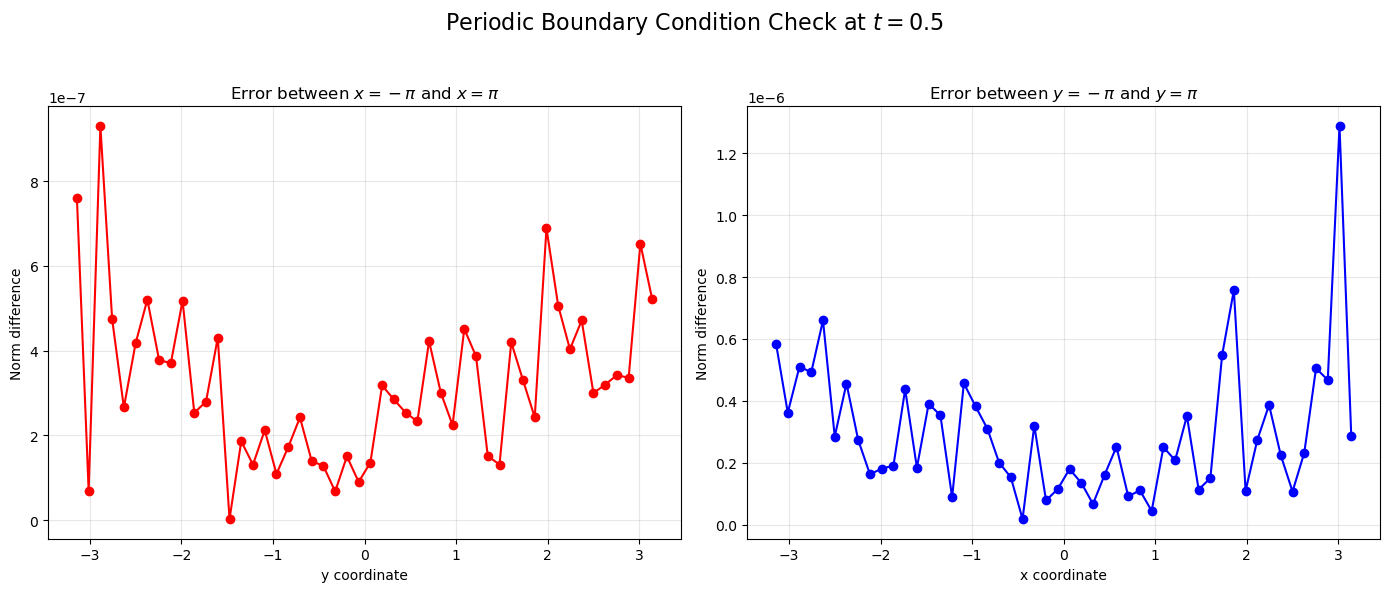

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Set device and t value
device = torch.device('cuda')
t_val = 0.5
pi = np.pi
n_samples = 50  # number of points along the boundary

# ============================
# Check periodicity in x-direction
# ============================
# For each y in [-pi, pi], compare vector_field at x = -pi and x = pi.
y_vals = np.linspace(-pi, pi, n_samples)

# Create tensors for boundary evaluation at x = -pi and x = pi.
x_left = torch.full((n_samples, 1), -pi, dtype=torch.float32, device=device)
x_right = torch.full((n_samples, 1), pi, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y_vals, dtype=torch.float32, device=device).unsqueeze(1)
t_tensor = torch.full((n_samples, 1), t_val, dtype=torch.float32, device=device)

# Evaluate the model on the left and right boundaries.
trained_model.eval()
with torch.no_grad():
    vector_left = trained_model(x_left, y_tensor, t_tensor)
    vector_right = trained_model(x_right, y_tensor, t_tensor)

# Move to CPU and convert to NumPy arrays.
vector_left = vector_left.cpu().numpy()
vector_right = vector_right.cpu().numpy()

# Compute the norm of the difference for each y coordinate.
error_x = np.linalg.norm(vector_left - vector_right, axis=1)

# ============================
# Check periodicity in y-direction
# ============================
# For each x in [-pi, pi], compare vector_field at y = -pi and y = pi.
x_vals = np.linspace(-pi, pi, n_samples)
x_tensor = torch.tensor(x_vals, dtype=torch.float32, device=device).unsqueeze(1)
y_bottom = torch.full((n_samples, 1), -pi, dtype=torch.float32, device=device)
y_top = torch.full((n_samples, 1), pi, dtype=torch.float32, device=device)
t_tensor = torch.full((n_samples, 1), t_val, dtype=torch.float32, device=device)

with torch.no_grad():
    vector_bottom = trained_model(x_tensor, y_bottom, t_tensor)
    vector_top = trained_model(x_tensor, y_top, t_tensor)

vector_bottom = vector_bottom.cpu().numpy()
vector_top = vector_top.cpu().numpy()

# Compute the norm of the difference for each x coordinate.
error_y = np.linalg.norm(vector_bottom - vector_top, axis=1)

# ============================
# Visualization of the periodicity check results
# ============================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the error along the x-boundaries as a function of y.
axes[0].plot(y_vals, error_x, 'o-', color='red')
axes[0].set_title('Error between $x=-\pi$ and $x=\pi$')
axes[0].set_xlabel('y coordinate')
axes[0].set_ylabel('Norm difference')
axes[0].grid(True, alpha=0.3)

# Plot the error along the y-boundaries as a function of x.
axes[1].plot(x_vals, error_y, 'o-', color='blue')
axes[1].set_title('Error between $y=-\pi$ and $y=\pi$')
axes[1].set_xlabel('x coordinate')
axes[1].set_ylabel('Norm difference')
axes[1].grid(True, alpha=0.3)

fig.suptitle(f'Periodic Boundary Condition Check at $t={t_val}$', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## call the saved model

In [ ]:
model = torch.load("PINN_Vonmise.pth")
model

PINN2D(
  (input_layer): Linear(in_features=3, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-5): 6 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
  (activation): Tanh()
)

## Define the integral function

In [ ]:
def solve_ivp_torch(fun: nn.Module, t_span, y0, method='RK45', rtol=1e-3, atol=1e-6):
    """
    A batch-friendly ODE solver using SciPy's solve_ivp internally.
    NOTE: Results are not differentiable through PyTorch autograd.
    """
    B, ND = y0.shape
    device = y0.device

    def fun_wrapper(t, y):
        # 1) Convert incoming y (numpy array) to a PyTorch tensor
        y_torch = torch.from_numpy(y).float().to('cuda').reshape(-1, ND)

        # 2) Convert scalar t to a tensor of shape (B, 1)
        t_torch = torch.ones_like(y_torch[:, :1], device='cuda') * t

        # 3) Evaluate the user-specified function (the ODE’s right-hand side)
        vt = fun(y_torch[:,0:1],y_torch[:,1:2], t_torch)

        # 4) Convert the result back to numpy, flatten
        return vt.detach().cpu().numpy().reshape(-1)

    # Flatten initial y0 to shape (B*ND,)
    import numpy as np
    from scipy.integrate import solve_ivp

    y0_np = y0.detach().cpu().numpy().reshape(-1)

    sol = solve_ivp(
        fun_wrapper,
        t_span,
        y0_np,
        method=method,
        rtol=rtol,
        atol=atol
    )

    # Return the final solution at t_span[-1], shape (B, ND)
    final_y = sol.y[:, -1]
    final_y_torch = torch.from_numpy(final_y).float().to(device).reshape(B, ND)
    return final_y_torch

torch.Size([100000, 2])
x range: -3.141522169113159 3.1415436267852783
y range: -3.141525983810425 3.1414449214935303


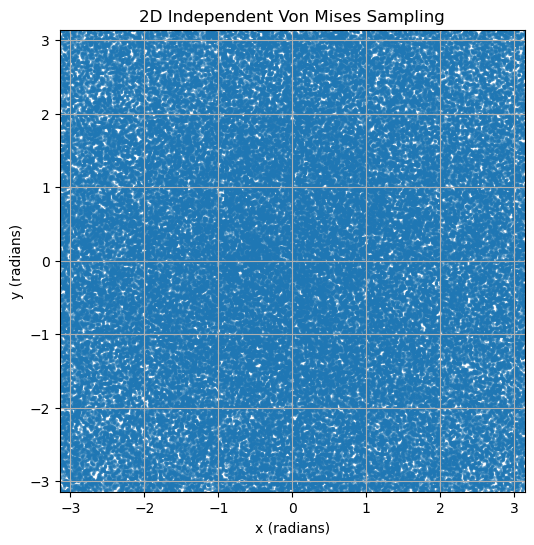

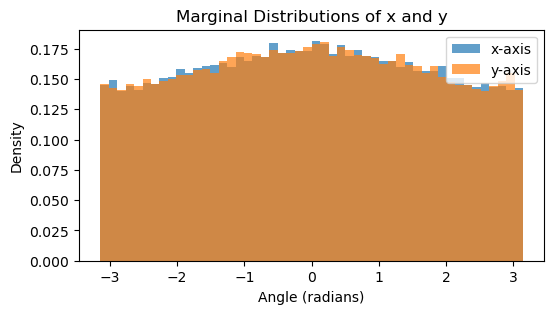

In [ ]:
import torch
import math
import matplotlib.pyplot as plt

import torch
import math
import matplotlib.pyplot as plt

# 设定样本数量
num_samples = 100000

# 设定 Von Mises 分布参数
mu_x = 0.0      # x 方向均值角度
mu_y = 0.0      # y 方向均值角度
kappa_x = 0.1   # x 方向集中度
kappa_y = 0.1   # y 方向集中度

# 1. 分别从两个独立的 Von Mises 分布中采样 x 和 y
dist_x = torch.distributions.VonMises(mu_x, kappa_x)
dist_y = torch.distributions.VonMises(mu_y, kappa_y)

samples_x = dist_x.sample((num_samples,))
samples_y = dist_y.sample((num_samples,))

# 2. 确保所有样本严格在 [-π, π] 盒子里（一般不需要，因为 PyTorch 采样默认在 [-π, π]）
samples_x = torch.remainder(samples_x + math.pi, 2 * math.pi) - math.pi
samples_y = torch.remainder(samples_y + math.pi, 2 * math.pi) - math.pi

# 3. 组合成 2D 样本
samples_2d = torch.stack((samples_x, samples_y), dim=1)  # shape: [10000, 2]

# 输出形状检查
print(samples_2d.shape)  # 应该是 [10000, 2]
print("x range:", samples_x.min().item(), samples_x.max().item())
print("y range:", samples_y.min().item(), samples_y.max().item())

# 4. 可视化结果
plt.figure(figsize=(6,6))
plt.scatter(samples_x.numpy(), samples_y.numpy(), s=2, alpha=0.5)
plt.xlim(-math.pi, math.pi)
plt.ylim(-math.pi, math.pi)
plt.xlabel("x (radians)")
plt.ylabel("y (radians)")
plt.title("2D Independent Von Mises Sampling")
plt.grid(True)
plt.show()

# 5. 分别绘制 x 和 y 的直方图
plt.figure(figsize=(6,3))
plt.hist(samples_x.numpy(), bins=50, alpha=0.7, density=True, label="x-axis")
plt.hist(samples_y.numpy(), bins=50, alpha=0.7, density=True, label="y-axis")
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Marginal Distributions of x and y")
plt.legend()
plt.show()

torch.Size([100000, 2])
x range: -3.1414687633514404 3.1413938999176025
y range: -3.1411821842193604 3.141573190689087


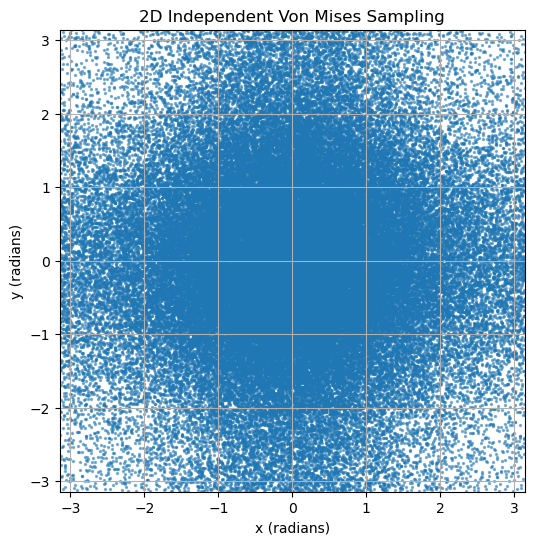

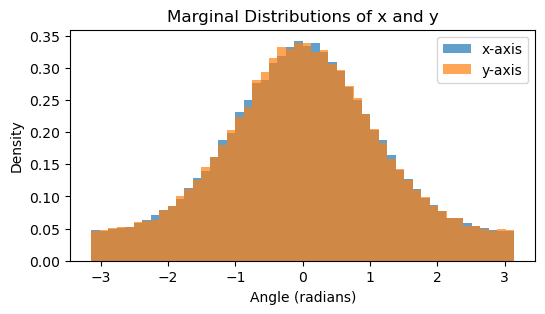

In [ ]:
num_samples = 100000

# 设定 Von Mises 分布参数
mu_x = 0.0      # x 方向均值角度
mu_y = 0.0      # y 方向均值角度
kappa_x = 1   # x 方向集中度
kappa_y = 1   # y 方向集中度

# 1. 分别从两个独立的 Von Mises 分布中采样 x 和 y
dist_x = torch.distributions.VonMises(mu_x, kappa_x)
dist_y = torch.distributions.VonMises(mu_y, kappa_y)

samples_x = dist_x.sample((num_samples,))
samples_y = dist_y.sample((num_samples,))

# 2. 确保所有样本严格在 [-π, π] 盒子里（一般不需要，因为 PyTorch 采样默认在 [-π, π]）
samples_x = torch.remainder(samples_x + math.pi, 2 * math.pi) - math.pi
samples_y = torch.remainder(samples_y + math.pi, 2 * math.pi) - math.pi

# 3. 组合成 2D 样本
samples_2d_concentrated = torch.stack((samples_x, samples_y), dim=1)  # shape: [10000, 2]

# 输出形状检查
print(samples_2d_concentrated.shape)  # 应该是 [10000, 2]
print("x range:", samples_x.min().item(), samples_x.max().item())
print("y range:", samples_y.min().item(), samples_y.max().item())

# 4. 可视化结果
plt.figure(figsize=(6,6))
plt.scatter(samples_x.numpy(), samples_y.numpy(), s=2, alpha=0.5)
plt.xlim(-math.pi, math.pi)
plt.ylim(-math.pi, math.pi)
plt.xlabel("x (radians)")
plt.ylabel("y (radians)")
plt.title("2D Independent Von Mises Sampling")
plt.grid(True)
plt.show()

# 5. 分别绘制 x 和 y 的直方图
plt.figure(figsize=(6,3))
plt.hist(samples_x.numpy(), bins=50, alpha=0.7, density=True, label="x-axis")
plt.hist(samples_y.numpy(), bins=50, alpha=0.7, density=True, label="y-axis")
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Marginal Distributions of x and y")
plt.legend()
plt.show()

In [ ]:
# Suppose ND=2, so our state y = (x, v) or something like that
# We'll define a network with input_dim=ND+1=3, hidden_dim=16, output_dim=ND=2

# Integrate from t = 0 to t = 1
t_span = (0.1, 1.0)

# Solve
final_y = solve_ivp_torch(Velocity, t_span, samples_2d)
print(final_y.shape)

torch.Size([100000, 2])


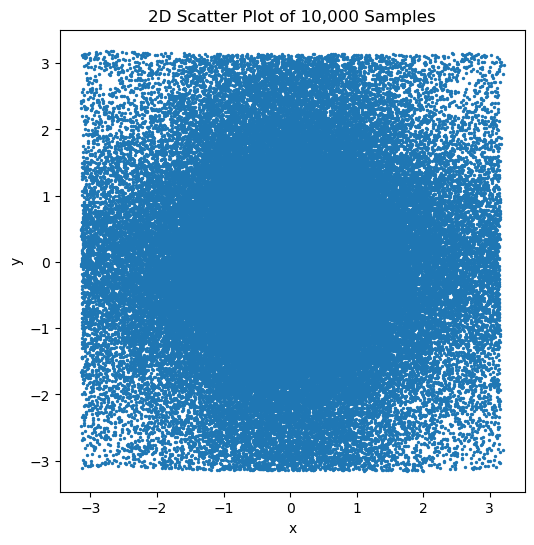

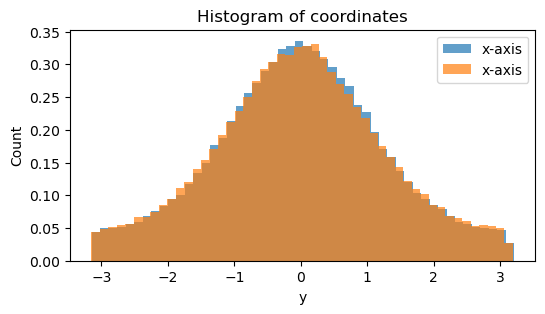

In [ ]:
samples_np = final_y.cpu().numpy()

x_vals = samples_np[:, 0]
y_vals = samples_np[:, 1]

# 1) Scatter plot of (x, y)
plt.figure(figsize=(6,6))
plt.scatter(x_vals, y_vals, s=2)  # s=2 => smaller marker size
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Scatter Plot of 10,000 Samples")
plt.show()

# 2) Histogram of x
plt.figure(figsize=(6,3))
plt.hist(x_vals, bins=50, alpha=0.7, density=True, label="x-axis")
plt.hist(y_vals, bins=50, alpha=0.7, density=True, label="x-axis")
plt.xlabel("y")
plt.ylabel("Count")
plt.title("Histogram of coordinates")
plt.legend()
plt.show()

In [ ]:
kappa = torch.linspace(0.1, 1.0, steps=100, requires_grad=True)

Time_residual.eval()
with torch.no_grad():  # No need for gradients here
    c_test = Time_residual(kappa.view(100,1).to('cuda'))
c_test

tensor([[0.0155],
        [0.0193],
        [0.0231],
        [0.0271],
        [0.0310],
        [0.0350],
        [0.0390],
        [0.0430],
        [0.0471],
        [0.0513],
        [0.0554],
        [0.0596],
        [0.0638],
        [0.0681],
        [0.0723],
        [0.0766],
        [0.0810],
        [0.0853],
        [0.0897],
        [0.0941],
        [0.0985],
        [0.1029],
        [0.1074],
        [0.1119],
        [0.1164],
        [0.1209],
        [0.1254],
        [0.1299],
        [0.1344],
        [0.1390],
        [0.1435],
        [0.1481],
        [0.1526],
        [0.1572],
        [0.1618],
        [0.1663],
        [0.1709],
        [0.1754],
        [0.1799],
        [0.1845],
        [0.1890],
        [0.1935],
        [0.1980],
        [0.2025],
        [0.2069],
        [0.2114],
        [0.2158],
        [0.2202],
        [0.2246],
        [0.2289],
        [0.2333],
        [0.2376],
        [0.2419],
        [0.2461],
        [0.2503],
        [0

In [ ]:
# Define the function ln(2 * pi * I0(kappa))
f = torch.log(2 * torch.pi * torch.special.i0(kappa))

# Compute the derivative (gradient) w.r.t. kappa by summing f and calling autograd
gradient = torch.autograd.grad(outputs=f.sum(), inputs=kappa)[0]
gradient

tensor([0.0499, 0.0545, 0.0590, 0.0635, 0.0680, 0.0725, 0.0770, 0.0815, 0.0860,
        0.0905, 0.0950, 0.0995, 0.1040, 0.1084, 0.1129, 0.1174, 0.1218, 0.1263,
        0.1307, 0.1351, 0.1395, 0.1439, 0.1483, 0.1527, 0.1571, 0.1615, 0.1658,
        0.1702, 0.1745, 0.1789, 0.1832, 0.1875, 0.1918, 0.1961, 0.2004, 0.2046,
        0.2089, 0.2131, 0.2174, 0.2216, 0.2258, 0.2300, 0.2342, 0.2383, 0.2425,
        0.2466, 0.2508, 0.2549, 0.2590, 0.2631, 0.2671, 0.2712, 0.2752, 0.2793,
        0.2833, 0.2873, 0.2912, 0.2952, 0.2992, 0.3031, 0.3070, 0.3109, 0.3148,
        0.3187, 0.3225, 0.3264, 0.3302, 0.3340, 0.3378, 0.3415, 0.3453, 0.3490,
        0.3527, 0.3564, 0.3601, 0.3638, 0.3674, 0.3711, 0.3747, 0.3783, 0.3819,
        0.3854, 0.3890, 0.3925, 0.3960, 0.3995, 0.4030, 0.4064, 0.4098, 0.4133,
        0.4166, 0.4200, 0.4234, 0.4267, 0.4301, 0.4334, 0.4366, 0.4399, 0.4432,
        0.4464])

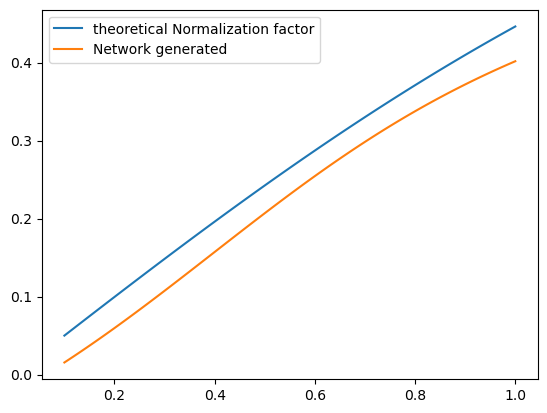

In [ ]:
plt.plot(np.linspace(0.1, 1.0,100),gradient.numpy(), label = 'theoretical Normalization factor')
plt.plot(np.linspace(0.1, 1.0,100),c_test.cpu().numpy(), label = 'Network generated')
plt.legend()
plt.show()

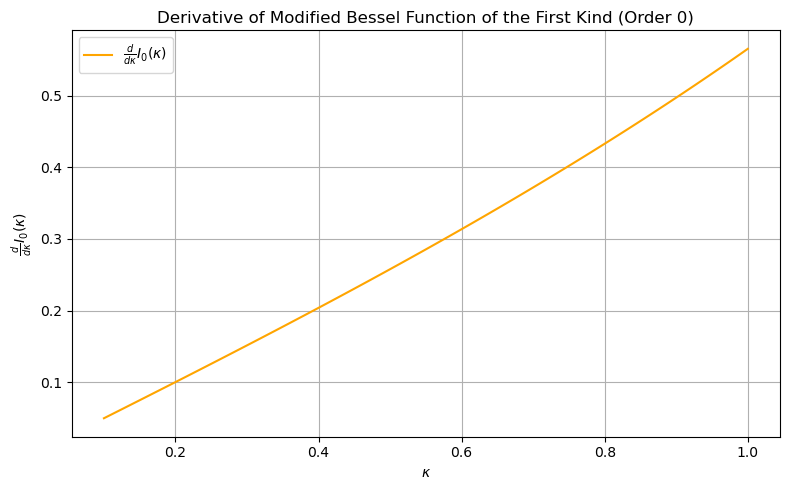

In [ ]:
from scipy.special import ivp

# Compute the derivative of the modified Bessel function of the first kind of order 0
dI0_dkappa = ivp(0, kappa.detach()).numpy()

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(kappa.detach().numpy(), dI0_dkappa, label=r"$\frac{d}{d\kappa}I_0(\kappa)$", color="orange")
plt.xlabel(r'$\kappa$')
plt.ylabel(r"$\frac{d}{d\kappa}I_0(\kappa)$")
plt.title('Derivative of Modified Bessel Function of the First Kind (Order 0)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()